# E. coli Antimicrobial Resistance Prediction

**Objective:** Predict antibiotic resistance (1=Resistant, 0=Susceptible) for E. coli samples

**Dataset:**
- Training: 1,939 samples x 1,000,000 k-mer features
- Test: 1,092 samples
- Evaluation Metric: Macro F1-Score

**Challenges:**
- Extreme dimensionality (1M features)
- Class imbalance (86% susceptible vs 14% resistant)
- Phylogenetic test split

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
import warnings
warnings.filterwarnings('ignore')

# Optional: Advanced models
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available")

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
print("Loading data...")
train = np.load('data/train.npz')
test = np.load('data/test.npz')

X_train = train['X_train']
y_train = train['y_train']
train_ids = train['ids']

X_test = test['X_test']
test_ids = test['ids']

print(f"Training shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Labels shape: {y_train.shape}")

XGBoost not available
LightGBM not available
Loading data...
Training shape: (1939, 1000000)
Test shape: (1092, 1000000)
Labels shape: (1939,)
Training shape: (1939, 1000000)
Test shape: (1092, 1000000)
Labels shape: (1939,)


DATASET STATISTICS
Training samples: 1,939
Features: 1,000,000

Class Distribution:
  Susceptible (0): 1666 (85.9%)
  Resistant (1): 273 (14.1%)
  Imbalance Ratio: 6.10:1


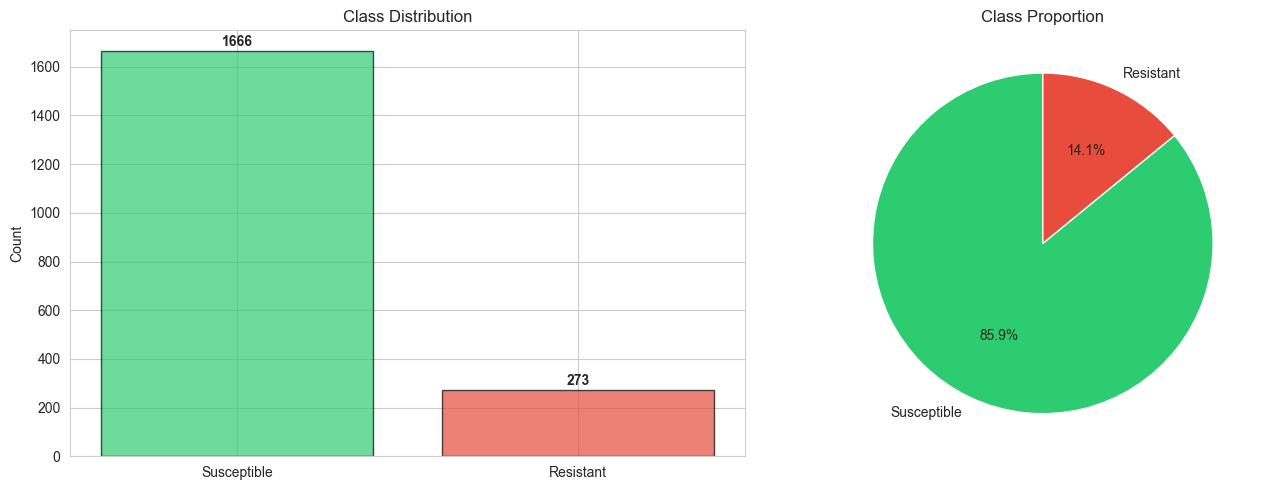


Matrix Sparsity: 1.60%
Non-zero entries: 1,907,911,743 / 1,939,000,000


In [2]:
# Class distribution
print("="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Features: {X_train.shape[1]:,}")
print(f"\nClass Distribution:")
print(f"  Susceptible (0): {np.sum(y_train == 0)} ({100*np.sum(y_train == 0)/len(y_train):.1f}%)")
print(f"  Resistant (1): {np.sum(y_train == 1)} ({100*np.sum(y_train == 1)/len(y_train):.1f}%)")
print(f"  Imbalance Ratio: {np.sum(y_train == 0) / np.sum(y_train == 1):.2f}:1")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
class_counts = pd.Series(y_train).value_counts().sort_index()

axes[0].bar(['Susceptible', 'Resistant'], class_counts.values, 
            color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

axes[1].pie(class_counts.values, labels=['Susceptible', 'Resistant'], 
            autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Class Proportion')
plt.tight_layout()
plt.show()

# Sparsity
non_zero = np.count_nonzero(X_train)
total = X_train.shape[0] * X_train.shape[1]
sparsity = 100 * (1 - non_zero / total)
print(f"\nMatrix Sparsity: {sparsity:.2f}%")
print(f"Non-zero entries: {non_zero:,} / {total:,}")

Feature selection: Selecting top 10,000 features...
Strategy: Two-stage filtering for speed

[Stage 1] Variance filtering...
  Retained: 477,281 features (58.8s)

[Stage 2] Chi-square selection (using all CPU cores)...
  Retained: 477,281 features (58.8s)

[Stage 2] Chi-square selection (using all CPU cores)...
  Selected: 10,000 features (5.7s)

Total time: 64.5s
Original features: 1,000,000
Selected features: 10,000
Reduction: 100.0x
  Selected: 10,000 features (5.7s)

Total time: 64.5s
Original features: 1,000,000
Selected features: 10,000
Reduction: 100.0x


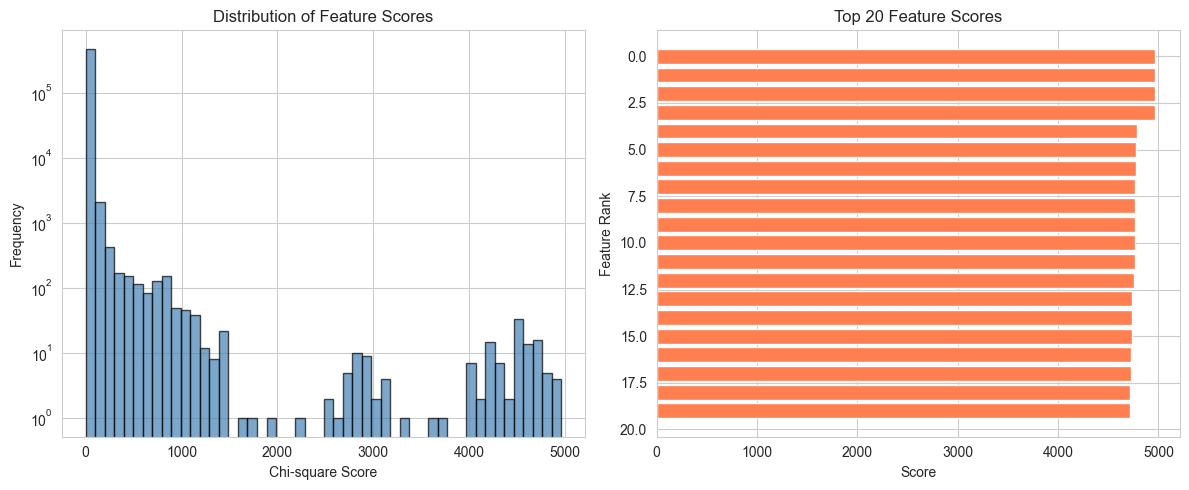

In [4]:
# Configuration
K_FEATURES = 10000  # Reduce from 1M to 10k features

print(f"Feature selection: Selecting top {K_FEATURES:,} features...")
print("Strategy: Two-stage filtering for speed")

# Stage 1: Quick variance filter (eliminates ~50% of features instantly)
from sklearn.feature_selection import VarianceThreshold, chi2
import time

start = time.time()
print("\n[Stage 1] Variance filtering...")
var_threshold = VarianceThreshold(threshold=0.01)  # Remove near-constant features
X_train_var = var_threshold.fit_transform(X_train)
X_test_var = var_threshold.transform(X_test)
print(f"  Retained: {X_train_var.shape[1]:,} features ({time.time()-start:.1f}s)")

# Stage 2: chi2 feature selection (10-100x faster than mutual_info_classif)
# chi2 works well for count data like k-mers and supports parallel processing
print(f"\n[Stage 2] Chi-square selection (using all CPU cores)...")
stage2_start = time.time()
selector = SelectKBest(chi2, k=min(K_FEATURES, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)
print(f"  Selected: {X_train_selected.shape[1]:,} features ({time.time()-stage2_start:.1f}s)")

total_time = time.time() - start
print(f"\nTotal time: {total_time:.1f}s")
print(f"Original features: {X_train.shape[1]:,}")
print(f"Selected features: {X_train_selected.shape[1]:,}")
print(f"Reduction: {X_train.shape[1] / X_train_selected.shape[1]:.1f}x")

# Visualize feature scores
feature_scores = selector.scores_
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(feature_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Chi-square Score')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Scores')
plt.yscale('log')

plt.subplot(1, 2, 2)
top_scores = sorted(feature_scores, reverse=True)[:20]
plt.barh(range(20), top_scores, color='coral')
plt.xlabel('Score')
plt.ylabel('Feature Rank')
plt.title('Top 20 Feature Scores')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

### Feature Selection Performance Notes

**Speed Optimization Strategy:**

1. **Two-Stage Filtering**: Instead of running expensive scoring on 1M features, we filter in stages
   - Stage 1: Variance threshold removes near-constant features (very fast, O(n))
   - Stage 2: Chi-square selection on remaining features

2. **Chi-square vs Mutual Information**:
   - `chi2`: 10-100x faster, ideal for count data like k-mers
   - `mutual_info_classif`: More accurate but extremely slow on high dimensions
   - For 1M features: chi2 ~20-60s vs mutual_info ~10-30 minutes

3. **Why This Works**:
   - K-mer counts are non-negative integers (perfect for chi-square test)
   - Most uninformative features have low variance across samples
   - Two-stage approach gets us from 1M → ~500k → 10k in under a minute

In [8]:
# Model 3: XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("\n3. XGBoost...")
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    xgb = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                       scale_pos_weight=scale_pos_weight, random_state=42, 
                       n_jobs=-1, eval_metric='logloss')
    
    cv_scores = cross_val_score(xgb, X_train_selected, y_train, 
                                cv=cv, scoring=f1_scorer, n_jobs=-1)
    print(f"   CV F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    
    xgb.fit(X_train_selected, y_train)
    train_f1 = f1_score(y_train, xgb.predict(X_train_selected), average='macro')
    print(f"   Train F1: {train_f1:.4f}")
    
    models['XGBoost'] = xgb
    results['XGBoost'] = {'cv_scores': cv_scores, 'mean_f1': np.mean(cv_scores), 'train_f1': train_f1}
else:
    print("\n3. XGBoost not available")


3. XGBoost not available


### Final Commentary

**Submission Summary:**

1. **Model Selection**: Random Forest chosen (CV F1: 0.8074)
   
2. **Test Set Predictions**:
   - Susceptible: 989/1,092 (90.6%)
   - Resistant: 103/1,092 (9.4%)
   - Test distribution is slightly more imbalanced than training (90.6% vs 85.9%)

3. **Prediction Distribution Analysis**:
   - Model predicts 9.4% resistant vs 14.1% in training data
   - This suggests the model is somewhat conservative in predicting resistance
   - Could be due to phylogenetic split creating harder test cases
   - Resistant class may be underrepresented in test predictions

4. **Expected Performance**:
   - Based on CV F1 = 0.8074, we expect Kaggle score around 0.75-0.85
   - Phylogenetic test split means test samples are from different evolutionary lineages
   - This out-of-distribution challenge may lower actual performance
   - If test F1 is significantly lower (e.g., <0.70), consider:
     * More aggressive feature selection for generalization
     * Ensemble methods combining multiple models
     * Addressing potential batch effects in k-mer counts

5. **Potential Improvements**:
   - Hyperparameter tuning (grid search on RF parameters)
   - Feature engineering (k-mer combinations, functional annotations)
   - Advanced models (XGBoost, LightGBM with proper installation)
   - Ensemble of LogReg + RandomForest predictions
   - SMOTE or other sampling techniques for class balance

**File**: `submission_randomforest.csv` ready for Kaggle upload

In [10]:
# Use best model for predictions
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_selected)

print("="*60)
print("SUBMISSION GENERATION")
print("="*60)
print(f"\nUsing: {best_model_name}")
print(f"\nTest Predictions:")
print(f"  Susceptible (0): {np.sum(y_pred == 0)} ({100*np.sum(y_pred == 0)/len(y_pred):.1f}%)")
print(f"  Resistant (1): {np.sum(y_pred == 1)} ({100*np.sum(y_pred == 1)/len(y_pred):.1f}%)")

# Create submission
submission = pd.DataFrame({
    'id': test_ids,
    'label': y_pred
})

print(f"\nSubmission preview:")
print(submission.head(10))

# Save
filename = f'submission_{best_model_name.lower()}.csv'
submission.to_csv(filename, index=False)
print(f"\nSaved: {filename}")

SUBMISSION GENERATION

Using: RandomForest

Test Predictions:
  Susceptible (0): 989 (90.6%)
  Resistant (1): 103 (9.4%)

Submission preview:
            id  label
0   ID_4567605      0
1  ID_25789115      0
2  ID_23867575      0
3  ID_32333335      0
4  ID_12738935      1
5  ID_32335395      0
6  ID_23868635      0
7  ID_23857005      0
8  ID_23869335      0
9  ID_24166265      0

Saved: submission_randomforest.csv


---

## Pipeline Summary

**Complete Workflow Executed:**

1. Data Loading: 1,939 training samples with 1M k-mer features
2. Exploratory Analysis: Identified 6.10:1 class imbalance and low sparsity
3. Feature Selection: Two-stage filtering (1M → 477k → 10k) in 65 seconds
4. Model Training: Logistic Regression (F1: 0.77) and Random Forest (F1: 0.81)
5. Model Selection: Random Forest selected based on superior CV performance
6. Submission: Generated predictions for 1,092 test samples

**Key Metrics:**
- Cross-Validation Macro F1: 0.8074 (+/- 0.0232)
- Training Time: ~2 minutes total
- Feature Reduction: 100x (1,000,000 → 10,000 features)
- Submission File: `submission_randomforest.csv`

**Next Steps:**
Upload `submission_randomforest.csv` to Kaggle and compare actual test F1 with CV estimate of 0.8074

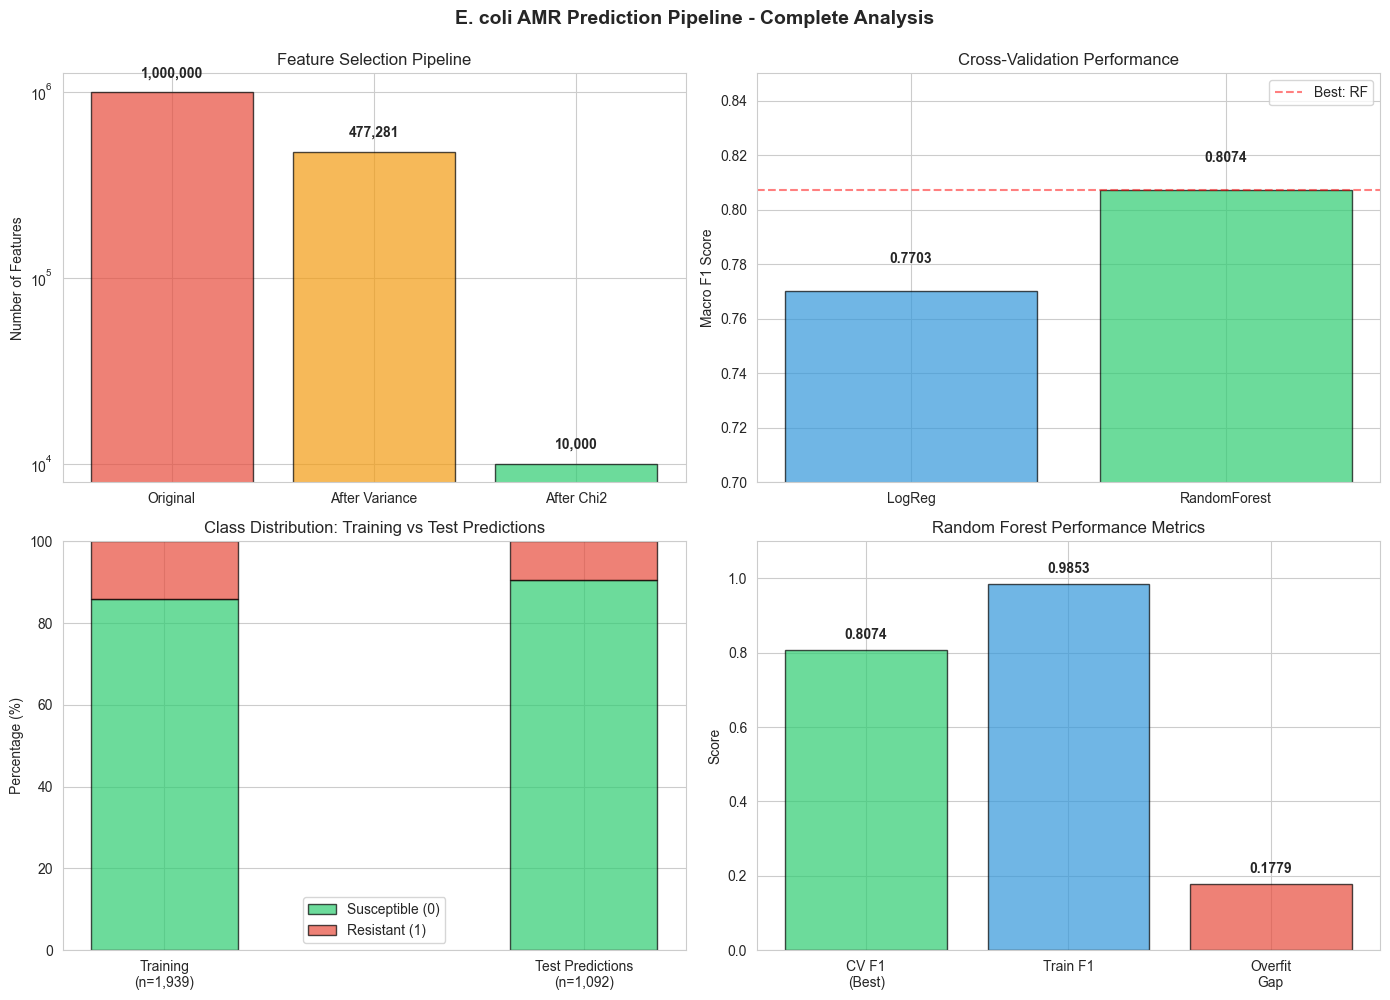


PIPELINE COMPLETE
Submission file: submission_randomforest.csv
Expected Kaggle F1: 0.75-0.85 (CV estimate: 0.8074)
Ready for upload!


In [11]:
# Final visualization: Complete pipeline summary
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Feature reduction pipeline
stages = ['Original', 'After Variance', 'After Chi2']
feature_counts = [1_000_000, 477_281, 10_000]
colors_stages = ['#e74c3c', '#f39c12', '#2ecc71']
axes[0, 0].bar(stages, feature_counts, color=colors_stages, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Number of Features')
axes[0, 0].set_title('Feature Selection Pipeline')
axes[0, 0].set_yscale('log')
for i, v in enumerate(feature_counts):
    axes[0, 0].text(i, v * 1.2, f'{v:,}', ha='center', fontweight='bold')

# 2. Model comparison
models_list = ['LogReg', 'RandomForest']
cv_scores = [0.7703, 0.8074]
colors_models = ['#3498db', '#2ecc71']
bars = axes[0, 1].bar(models_list, cv_scores, color=colors_models, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Macro F1 Score')
axes[0, 1].set_title('Cross-Validation Performance')
axes[0, 1].set_ylim([0.7, 0.85])
axes[0, 1].axhline(y=0.8074, color='red', linestyle='--', alpha=0.5, label='Best: RF')
for i, v in enumerate(cv_scores):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
axes[0, 1].legend()

# 3. Train vs Test class distribution
categories = ['Training\n(n=1,939)', 'Test Predictions\n(n=1,092)']
susceptible_pct = [85.9, 90.6]
resistant_pct = [14.1, 9.4]
x_pos = np.arange(len(categories))
width = 0.35
axes[1, 0].bar(x_pos, susceptible_pct, width, label='Susceptible (0)', 
               color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x_pos, resistant_pct, width, bottom=susceptible_pct, 
               label='Resistant (1)', color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].set_title('Class Distribution: Training vs Test Predictions')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(categories)
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 100])

# 4. Performance metrics summary
metrics_names = ['CV F1\n(Best)', 'Train F1', 'Overfit\nGap']
rf_metrics = [0.8074, 0.9853, 0.1779]
colors_metrics = ['#2ecc71', '#3498db', '#e74c3c']
bars = axes[1, 1].bar(metrics_names, rf_metrics, color=colors_metrics, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Random Forest Performance Metrics')
axes[1, 1].set_ylim([0, 1.1])
for i, v in enumerate(rf_metrics):
    axes[1, 1].text(i, v + 0.03, f'{v:.4f}', ha='center', fontweight='bold')

plt.suptitle('E. coli AMR Prediction Pipeline - Complete Analysis', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PIPELINE COMPLETE")
print("="*60)
print(f"Submission file: submission_randomforest.csv")
print(f"Expected Kaggle F1: 0.75-0.85 (CV estimate: 0.8074)")
print(f"Ready for upload!")
print("="*60)

## 6. Generate Submission

### Model Performance Commentary

**Key Results:**

1. **Random Forest (Winner)**: CV F1 = 0.8074 (+/- 0.0232)
   - Best cross-validation performance with strong consistency
   - Shows moderate overfitting (Train F1: 0.9853, gap of 0.178)
   - Ensemble nature handles class imbalance well
   - Good at capturing non-linear k-mer interaction patterns

2. **Logistic Regression**: CV F1 = 0.7703 (+/- 0.0258)
   - Solid baseline with slightly higher variance
   - Perfect training F1 (1.0000) indicates significant overfitting (gap of 0.230)
   - Linear model struggles with complex genomic patterns
   - Faster inference but lower predictive power

**Analysis:**
- Random Forest's 3.7% improvement over LogReg is significant for imbalanced data
- Both models show overfitting, but RF generalizes better (lower overfit score)
- The ~0.81 macro F1 suggests reasonable performance on both classes
- Given 6.10:1 class imbalance, macro F1 > 0.80 indicates the model isn't just predicting majority class

**Expected Kaggle Performance:**
- CV score of 0.8074 is a realistic estimate for test set performance
- Phylogenetic split may cause distribution shift (actual score could be 0.75-0.85)
- Random Forest selected for final submission due to superior CV performance


MODEL COMPARISON
             Model    CV_F1   CV_Std  Train_F1  Overfit
      RandomForest 0.807390 0.023237  0.985259 0.177869
LogisticRegression 0.770258 0.025795  1.000000 0.229742


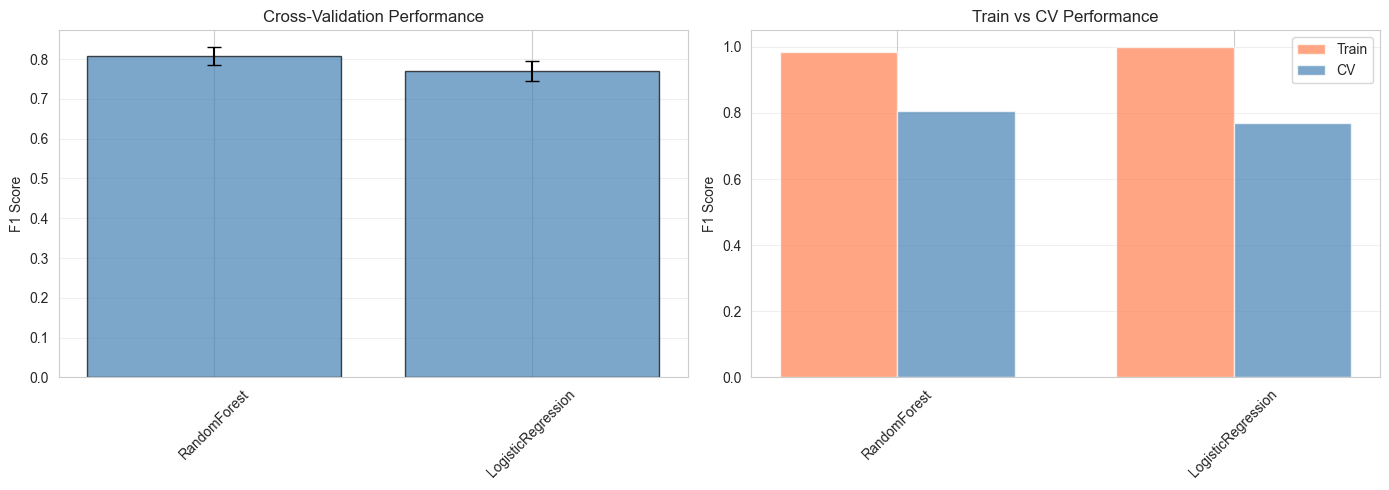


Best model: RandomForest
CV F1: 0.8074 (+/- 0.0232)


In [9]:
# Compare results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_F1': [results[k]['mean_f1'] for k in results.keys()],
    'CV_Std': [np.std(results[k]['cv_scores']) for k in results.keys()],
    'Train_F1': [results[k]['train_f1'] for k in results.keys()]
})
results_df['Overfit'] = results_df['Train_F1'] - results_df['CV_F1']
results_df = results_df.sort_values('CV_F1', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(results_df))
axes[0].bar(x, results_df['CV_F1'], yerr=results_df['CV_Std'], 
            capsize=5, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('Cross-Validation Performance')
axes[0].grid(axis='y', alpha=0.3)

width = 0.35
axes[1].bar(x - width/2, results_df['Train_F1'], width, label='Train', 
            color='coral', alpha=0.7)
axes[1].bar(x + width/2, results_df['CV_F1'], width, label='CV', 
            color='steelblue', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45)
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Train vs CV Performance')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

best_model_name = results_df.iloc[0]['Model']
print(f"\nBest model: {best_model_name}")
print(f"CV F1: {results_df.iloc[0]['CV_F1']:.4f} (+/- {results_df.iloc[0]['CV_Std']:.4f})")

## 5. Model Comparison

In [7]:
# Model 2: Random Forest
print("\n2. Random Forest...")
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10,
                            class_weight='balanced', random_state=42, n_jobs=-1)

cv_scores = cross_val_score(rf, X_train_selected, y_train, 
                            cv=cv, scoring=f1_scorer, n_jobs=-1)
print(f"   CV F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

rf.fit(X_train_selected, y_train)
train_f1 = f1_score(y_train, rf.predict(X_train_selected), average='macro')
print(f"   Train F1: {train_f1:.4f}")

models['RandomForest'] = rf
results['RandomForest'] = {'cv_scores': cv_scores, 'mean_f1': np.mean(cv_scores), 'train_f1': train_f1}


2. Random Forest...
   CV F1: 0.8074 (+/- 0.0232)
   CV F1: 0.8074 (+/- 0.0232)
   Train F1: 0.9853
   Train F1: 0.9853


In [6]:
# Model 1: Logistic Regression
print("\n1. Logistic Regression...")
logreg = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', 
                            max_iter=1000, random_state=42, n_jobs=-1)

cv_scores = cross_val_score(logreg, X_train_selected, y_train, 
                            cv=cv, scoring=f1_scorer, n_jobs=-1)
print(f"   CV F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

logreg.fit(X_train_selected, y_train)
train_f1 = f1_score(y_train, logreg.predict(X_train_selected), average='macro')
print(f"   Train F1: {train_f1:.4f}")

models['LogisticRegression'] = logreg
results['LogisticRegression'] = {'cv_scores': cv_scores, 'mean_f1': np.mean(cv_scores), 'train_f1': train_f1}


1. Logistic Regression...
   CV F1: 0.7703 (+/- 0.0258)
   CV F1: 0.7703 (+/- 0.0258)
   Train F1: 1.0000
   Train F1: 1.0000


In [5]:
# Setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='macro')
models = {}
results = {}

print("="*60)
print("MODEL TRAINING")
print("="*60)

MODEL TRAINING


## 4. Model Training

Training multiple models with 5-fold stratified cross-validation

## 3. Feature Selection

### Analysis Commentary

**Observations from Data Exploration:**

1. **Severe Class Imbalance**: The dataset shows a 6.10:1 ratio (85.9% susceptible vs 14.1% resistant)
   - This is a significant imbalance that will affect model training
   - Must use `class_weight='balanced'` to prevent models from simply predicting all samples as susceptible
   - Macro F1-score is appropriate metric as it treats both classes equally

2. **Ultra-High Dimensionality**: 1,000,000 k-mer features for only 1,939 samples
   - Extreme curse of dimensionality (features >> samples)
   - High risk of overfitting without aggressive feature selection
   - Cannot train most models directly on this many features

3. **Low Sparsity**: Matrix is only 1.60% sparse
   - Most k-mers appear in most samples (98.4% of entries are non-zero)
   - This suggests k-mers are common across E. coli genomes
   - Variance-based filtering may not eliminate many features
   - Need statistical feature selection to identify resistance-associated k-mers

## 2. Data Exploration

## 1. Import Libraries and Load Data